In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import itertools
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

In [2]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()

subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
subject_data['timestamp_rounded'] = subject_data['timestamp'].round(3)

grouped = subject_data.groupby('timestamp_rounded')
real_data = []

for ts, group in grouped:
    entry = {'timestamp': ts}
    left = group[group['side'] == 'left']
    right = group[group['side'] == 'right']
    
    if not left.empty:
        left_xy = left[['X', 'Y']].iloc[0].to_numpy()
        entry['left'] = left_xy
    if not right.empty:
        right_xy = right[['X', 'Y']].iloc[0].to_numpy()
        entry['right'] = right_xy
    
    if 'left' in entry and 'right' in entry:
        entry['observed'] = 'both'
        entry['obs'] = np.concatenate([entry['left'], entry['right']])
    elif 'left' in entry:
        entry['observed'] = 'left'
        entry['obs'] = entry['left']
    elif 'right' in entry:
        entry['observed'] = 'right'
        entry['obs'] = entry['right']
    else:
        entry['observed'] = 'none'
        entry['obs'] = np.array([])

    real_data.append(entry)

In [62]:
DT_VIRT = 0.5
SIGMA_MIN = 0.000001
SIGMA_MAX = 1.0
SIGMA_OBS_MIN = 0.1
SIGMA_OBS_MAX = 10.0
sigma_v_values = [0.01, 0.05, 0.1, 0.5]
sigma_omega_values = [0.001, 0.01, 0.05, 0.1]
sigma_obs_values = [0.5, 1]
param_combinations = list(itertools.product(sigma_v_values, sigma_omega_values, sigma_obs_values))
results = []

In [63]:
def angle_residual(a, b):
    y = a - b
    # Normalize to [-π, π]
    while y > np.pi:
        y -= 2*np.pi
    while y < -np.pi:
        y += 2*np.pi
    return y

def state_residual(a, b):
    res = a - b
    # res = np.zeros_like(a)
    # # [x, y, theta, vx, vy, omega]
    # res[0] = a[0] - b[0]
    # res[1] = a[1] - b[1]
    res[2] = angle_residual(a[2], b[2])
    # res[3] = a[3] - b[3]
    # res[4] = a[4] - b[4]
    # res[5] = a[5] - b[5]
    return res

def state_mean(sigmas, Wm):
    if len(sigmas.shape) == 1:
        # Single sigma point
        return sigmas.copy()
    
    X = np.dot(Wm, sigmas) / np.sum(Wm)

    # # Initialize mean
    # x = np.zeros(sigmas.shape[1])
    
    # # Linear states: x, y, vx, vy, omega
    # linear_indices = [0, 1, 3, 4, 5]
    # for i in linear_indices:
    #     x[i] = np.average(sigmas[:, i], weights=Wm)
    
    # Use circular mean for angular components
    angles = sigmas[:, 2]
    sin_sum = np.sum(Wm * np.sin(angles))
    cos_sum = np.sum(Wm * np.cos(angles))
    x[2] = np.arctan2(sin_sum, cos_sum)
    
    return x

def measurement_residual(a, b):
    return a - b

def normalize_angle(angle):
    while angle > np.pi:
        angle -= 2*np.pi
    while angle < -np.pi:
        angle += 2*np.pi
    return angle

def state_transition(state, dt, sigma_v=None, sigma_omega=None):
    x, y, theta, vx, vy, omega = state
    new_state = np.array([
        x + vx * dt,
        y + vy * dt,
        theta + omega * dt,
        vx,
        vy,
        omega
    ])
    new_state[2] = normalize_angle(new_state[2])
    return new_state

def measurement_function(state, observed_sensors='both', d=0.23):
    x, y, theta = state[0], state[1], state[2]
    
    if observed_sensors == 'both':
        return np.array([
            x - d * np.sin(theta),  # left sensor x
            y + d * np.cos(theta),  # left sensor y
            x + d * np.sin(theta),  # right sensor x
            y - d * np.cos(theta)   # right sensor y
        ])
    elif observed_sensors == 'left':
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta)
        ])
    elif observed_sensors == 'right':
        return np.array([
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    else:  # 'none'
        return np.array([])

def create_ukf(initial_state, initial_P, sigma_v, sigma_omega, sigma_obs, d):
    # Create sigma points
    points = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2, kappa=3-6)
    
    ukf = UnscentedKalmanFilter(
        dim_x=6, dim_z=4, dt=0.1,
        hx=lambda x: measurement_function(x, 'both', d),
        fx=lambda x, dt: state_transition(x, dt, sigma_v, sigma_omega),
        points=points,
        residual_x=state_residual,
        residual_z=measurement_residual
    )
    
    # Try different ways to set the state mean function for compatibility
    try:
        ukf.x_mean_fn = state_mean
    except AttributeError:
        try:
            ukf.x_mean = state_mean
        except AttributeError:
            try:
                ukf.points_fn.x_mean = state_mean
            except AttributeError:
                print("Warning: Could not set custom state mean function. Using default.")
                pass
    
    ukf.x = initial_state.copy()
    ukf.x[2] = normalize_angle(ukf.x[2])
    ukf.P = initial_P.copy()
    
    return ukf

In [64]:
a = np.array([0, 6, 1, 3,5, 2])
is_realtimepoint = np.array([True, True, True, False, False, False])
idx = np.argsort(a)
print(idx)
print(a[idx])
print(is_realtimepoint[idx])

[0 2 5 3 4 1]
[0 1 2 3 5 6]
[ True  True False False False  True]


In [ ]:
def ensure_positive_definite(P, min_eigenvalue=1e-12):
    try:
        P_sym = (P + P.T) / 2
        # eigenvals, eigenvecs = np.linalg.eigh(P_sym)
        # eigenvals = np.maximum(eigenvals, min_eigenvalue)
        # # Reconstruct matrix
        # P_reg = eigenvecs @ np.diag(eigenvals) @ eigenvecs.T
        
        return P_sym
    except:
        print('ensure_positive_definite tried to add a diagonal component')
        print(P)
        return P + min_eigenvalue * np.eye(P.shape[0])

def ukf_forward(data, timestamps, master_timestamps, is_realtimepoint, params):
    print('current params:', params)
    sigma_v, sigma_omega, sigma_obs, d = params
    # master_timestamps = sorted(set(timestamps + virtual_timestamps))
    # is_realtimepoint = np.zeros(len(timestamps) + len(virtual_timestamps), dtype=bool)
    # is_realtimepoint[:len(timestamps)] = True
    # assert len(timestamps) + len(virtual_timestamps) == len(is_realtimepoint)
    # master_timestamps = np.array(timestamps + virtual_timestamps)
    # idx_sort = np.argsort(master_timestamps)
    # master_timestamps = master_timestamps[idx_sort]
    # is_realtimepoint = is_realtimepoint[idx_sort]

    T = len(master_timestamps)
    
    initial_state = np.zeros(6)
    found_initial = False
    
    left_coords = []
    right_coords = []
    for entry in data[:20]:
        if entry['observed'] != 'none':
            if entry['observed'] == 'left' and 'left' in entry:
                left_coords.append(entry['left'])
                # initial_state[:2] = entry['left']
                # found_initial = True
                # break
            elif entry['observed'] == 'right' and 'right' in entry:
                right_coords.append(entry['right'])
                # initial_state[:2] = entry['right']
                # found_initial = True
                # break
            elif entry['observed'] == 'both' and 'left' in entry and 'right' in entry:
                left_coords.append(entry['left'])
                right_coords.append(entry['right'])
                # initial_state[:2] = (np.array(entry['left']) + np.array(entry['right'])) / 2
                # found_initial = True
                # break
    if left_coords and right_coords:
        left_coords = np.array(left_coords)
        right_coords = np.array(right_coords)
        initial_state[:2] = (np.mean(left_coords, axis=0) + np.mean(right_coords, axis=0)) / 2
        initial_state[2] = np.arctan2(np.mean(right_coords[:, 1]) - np.mean(left_coords[:, 1]), 
                                      np.mean(right_coords[:, 0]) - np.mean(left_coords[:, 0])) + np.pi / 2
        initial_state[2] = normalize_angle(initial_state[2])
        found_initial = True
    
    if not found_initial:
        print("Warning: Could not find valid initial state")
        initial_state[:2] = [0, 0]
    
    # initial_P = np.diag([1.0, 1.0, 1.0, 0.5, 0.5, 0.1])
    initial_P = np.diag([10.0, 10.0, 1.5, 1.0, 1.0, 0.5])
    initial_P = ensure_positive_definite(initial_P)
    
    ukf = create_ukf(initial_state, initial_P, sigma_v, sigma_omega, sigma_obs, d)
    
    states_pred = []
    states_filt = []
    covariances_pred = []
    covariances_filt = []
    neg_log_likelihood = 0.0
    
    for k in range(T):
        t_k = master_timestamps[k]
        
        ukf.P = ensure_positive_definite(ukf.P)
        
        if k > 0:
            dt = t_k - master_timestamps[k-1]
            # dt = max(dt, 1e-6)  # Prevent zero dt
            # dt = min(dt, 1.0)   # Prevent excessively large dt
            
            # Process noise covariance - more conservative values
            Q = np.zeros((6, 6))
            # Add small process noise to position for numerical stability
            # Q[0, 0] = 1e-6
            # Q[1, 1] = 1e-6
            # Q[2, 2] = 1e-6
            # Q[3, 3] = max(sigma_v**2 * dt, 1e-6)
            # Q[4, 4] = max(sigma_v**2 * dt, 1e-6)
            # Q[5, 5] = max(sigma_omega**2 * dt, 1e-6)
            Q[3, 3] = sigma_v**2 * dt + 1e-12
            Q[4, 4] = sigma_v**2 * dt + 1e-12
            Q[5, 5] = sigma_omega**2 * dt + 1e-12
            
            ukf.Q = Q
            
            try:
                # Store original state for fallback
                x_backup = ukf.x.copy()
                P_backup = ukf.P.copy()
                
                ukf.predict(dt=dt)
                
                # Manual angle normalization
                ukf.x[2] = normalize_angle(ukf.x[2])
                
                # Ensure covariance remains positive definite after prediction
                ukf.P = ensure_positive_definite(ukf.P)
                
                # Check for reasonable state values
                if not np.all(np.isfinite(ukf.x)):
                    print(f"Invalid state after prediction at step {k}, using backup")
                    ukf.x = x_backup
                    ukf.P = ensure_positive_definite(P_backup)
                    
            except Exception as e:
                print(f"Prediction failed at step {k}: {e}")
                print(ukf.x)
                print(ukf.P)
                print(covariances_pred[-1])
                # Use previous state if prediction fails
                if states_filt:
                    ukf.x = states_filt[-1].copy()
                    ukf.x[2] = normalize_angle(ukf.x[2])
                    ukf.P = ensure_positive_definite(covariances_filt[-1])
                else:
                    # Reset to initial conditions
                    ukf.P = ensure_positive_definite(initial_P)
                neg_log_likelihood = np.inf
                break
        
        states_pred.append(ukf.x.copy())
        covariances_pred.append(ukf.P.copy())
        
        if is_realtimepoint[k]:
            idx = timestamps.index(t_k)
            observed_sensors = data[idx]['observed']
            
            if observed_sensors != 'none' and 'obs' in data[idx]:
                try:
                    # Set measurement function for current observation
                    ukf.hx = lambda x, sensors=observed_sensors, d_val=d: measurement_function(x, sensors, d_val)
                    
                    z = np.array(data[idx]['obs'])  # Ensure it's a numpy array
                    m_t = len(z)
                    
                    if m_t > 0:  # Only update if we have measurements
                        # More conservative measurement noise
                        R_val = max(sigma_obs**2, 1e-4)
                        ukf.R = R_val * np.eye(m_t)
                        
                        # Store backup before update
                        x_backup = ukf.x.copy()
                        P_backup = ukf.P.copy()
                        
                        # Compute predicted measurement for likelihood
                        z_pred = measurement_function(ukf.x, observed_sensors, d)
                        innovation = z - z_pred
                        
                        # Skip likelihood computation if innovation is too large (outlier)
                        # if np.linalg.norm(innovation) < 5.0:  # Reasonable threshold
                        # Numerical Jacobian for likelihood computation
                        # H_approx = np.zeros((m_t, 6))
                        # epsilon = 1e-6
                        # for i in range(6):
                        #     x_plus = ukf.x.copy()
                        #     x_minus = ukf.x.copy()
                        #     x_plus[i] += epsilon
                        #     x_minus[i] -= epsilon
                        #     h_plus = measurement_function(x_plus, observed_sensors, d)
                        #     h_minus = measurement_function(x_minus, observed_sensors, d)
                        #     H_approx[:, i] = (h_plus - h_minus) / (2 * epsilon)
                        
                        # # Innovation covariance
                        # S = H_approx @ ukf.P @ H_approx.T + ukf.R
                        # S = ensure_positive_definite(S, min_eigenvalue=1e-6)
                        
                        # # Calculate log likelihood contribution
                        # try:
                        #     sign, logdet = np.linalg.slogdet(S)
                        #     if sign > 0 and np.isfinite(logdet):
                        #         S_inv = np.linalg.inv(S)
                        #         likelihood_term = innovation @ S_inv @ innovation
                        #         if np.isfinite(likelihood_term) and likelihood_term >= 0:
                        #             neg_log_likelihood += 0.5 * (m_t * np.log(2 * np.pi) + logdet + likelihood_term)
                        # except (np.linalg.LinAlgError, ValueError):
                        #     print(f"Likelihood computation failed at step {k}")
                        
                        ukf.update(z)
                        
                        neg_log_likelihood -= ukf.log_likelihood
                        
                        # Manual angle normalization and validity check
                        ukf.x[2] = normalize_angle(ukf.x[2])
                        ukf.P = ensure_positive_definite(ukf.P)
                        
                        if not np.all(np.isfinite(ukf.x)):
                            print(f"Invalid state after update at step {k}, using backup")
                            ukf.x = x_backup
                            ukf.P = ensure_positive_definite(P_backup)
                        
                except Exception as e:
                    print(f"Update failed at step {k}: {e}")
                    # Ensure covariance is still valid
                    ukf.P = ensure_positive_definite(ukf.P)
        
        states_filt.append(ukf.x.copy())
        covariances_filt.append(ukf.P.copy())
    print(f"Total negative log likelihood: {neg_log_likelihood}")
    return states_filt, covariances_filt, states_pred, covariances_pred, neg_log_likelihood

In [66]:
def ukf_smoother(states_filt, covariances_filt, states_pred, covariances_pred, 
                 timestamps, virtual_timestamps, params):
    
    sigma_v, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    
    states_smooth = [s.copy() for s in states_filt]
    covariances_smooth = [ensure_positive_definite(P.copy()) for P in covariances_filt]
    
    # Backward pass
    for k in range(T - 2, -1, -1):
        dt = master_timestamps[k + 1] - master_timestamps[k]
        dt = max(dt, 1e-6)
        dt = min(dt, 1.0)
        
        F = np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        try:
            # Ensure matrices are positive definite
            P_filt_k = ensure_positive_definite(covariances_filt[k])
            P_pred_k1 = ensure_positive_definite(covariances_pred[k + 1])
            P_smooth_k1 = ensure_positive_definite(covariances_smooth[k + 1])
            
            try:
                C = P_filt_k @ F.T @ np.linalg.inv(P_pred_k1)
            except np.linalg.LinAlgError:
                C = P_filt_k @ F.T @ np.linalg.pinv(P_pred_k1)
            
            state_diff = states_smooth[k + 1] - states_pred[k + 1]
            state_diff[2] = angle_residual(states_smooth[k + 1][2], states_pred[k + 1][2])
            
            states_smooth[k] = states_filt[k] + C @ state_diff
            states_smooth[k][2] = normalize_angle(states_smooth[k][2])  # Normalize angle
            
            cov_diff = P_smooth_k1 - covariances_pred[k + 1]
            covariances_smooth[k] = P_filt_k + C @ cov_diff @ C.T
            
            covariances_smooth[k] = ensure_positive_definite(covariances_smooth[k])
            
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Smoother failed at step {k}: {e}")
            states_smooth[k] = states_filt[k].copy()
            states_smooth[k][2] = normalize_angle(states_smooth[k][2])
            covariances_smooth[k] = ensure_positive_definite(covariances_filt[k])
    
    return states_smooth, covariances_smooth

def optimize_parameters_ukf(data, timestamps, virtual_timestamps, initial_params=None):
    if initial_params is None:
        initial_params = [0.1, 0.1, 0.1, 0.23]
    
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),
        (SIGMA_MIN, SIGMA_MAX),
        (SIGMA_OBS_MIN, SIGMA_OBS_MAX),
        (0.01, 1.0)
    ]
    
    is_realtimepoint = np.zeros(len(timestamps) + len(virtual_timestamps), dtype=bool)
    is_realtimepoint[:len(timestamps)] = True
    assert len(timestamps) + len(virtual_timestamps) == len(is_realtimepoint)
    master_timestamps = np.array(timestamps + virtual_timestamps)
    idx_sort = np.argsort(master_timestamps)
    master_timestamps = master_timestamps[idx_sort]
    is_realtimepoint = is_realtimepoint[idx_sort]

    def objective(params):
        try:
            _, _, _, _, neg_log_likelihood = ukf_forward(data, timestamps, master_timestamps, is_realtimepoint, params)
            if not np.isfinite(neg_log_likelihood):
                return 1e10
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            # return 1e10
            raise
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True, 'maxiter': 100, 'ftol': 1e-9}
    )
    print(result)
    
    return result.x

In [69]:
def run_ukf_test(real_data, param_combinations):
    results = []
    
    for i, (sigma_v, sigma_omega, sigma_obs) in enumerate(param_combinations):
        print(f"\nTest {i+1}")
        print(f"sigma_v: {sigma_v}, sigma_omega: {sigma_omega}, sigma_obs: {sigma_obs}")
        
        try:
            initial_params = [sigma_v, sigma_omega, sigma_obs, 0.23]
            max_data_points = 3000
            data_subset = real_data[:max_data_points]
            timestamps = [entry['timestamp'] for entry in data_subset]
            virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
            
            optimized_params = optimize_parameters_ukf(data_subset, timestamps, virtual_timestamps, initial_params)
            
            is_realtimepoint = np.zeros(len(timestamps) + len(virtual_timestamps), dtype=bool)
            is_realtimepoint[:len(timestamps)] = True
            assert len(timestamps) + len(virtual_timestamps) == len(is_realtimepoint)
            master_timestamps = np.array(timestamps + virtual_timestamps)
            idx_sort = np.argsort(master_timestamps)
            master_timestamps = master_timestamps[idx_sort]
            is_realtimepoint = is_realtimepoint[idx_sort]

            states_filt, covariances_filt, states_pred, covariances_pred, neg_log_likelihood = ukf_forward(
                data_subset, timestamps, master_timestamps, is_realtimepoint, optimized_params)
            
            states_smooth, covariances_smooth = ukf_smoother(
                states_filt, covariances_filt, states_pred, covariances_pred, 
                timestamps, virtual_timestamps, optimized_params)
            
            result_dict = {
                'combination_id': i+1,
                'initial_sigma_v': sigma_v,
                'initial_sigma_omega': sigma_omega,
                'initial_sigma_obs': sigma_obs,
                'optimized_sigma_v': optimized_params[0],
                'optimized_sigma_omega': optimized_params[1],
                'optimized_sigma_obs': optimized_params[2],
                'optimized_d': optimized_params[3],
                'negative_log_likelihood': neg_log_likelihood,
                'optimization_success': True
            }
            results.append(result_dict)
            print(f"Optimized params: {optimized_params}")
            print(f"Negative log-likelihood: {neg_log_likelihood}")

            plt.figure(figsize=(14, 10))
            plt.title(f'UKF Test {i+1}: sigma_v={sigma_v}, sigma_omega={sigma_omega}, sigma_obs={sigma_obs}')
            
            left_x, left_y = [], []
            right_x, right_y = [], []
            
            for entry in data_subset:
                if 'left' in entry and entry['left'] is not None:
                    left_x.append(entry['left'][0])
                    left_y.append(entry['left'][1])
                if 'right' in entry and entry['right'] is not None:
                    right_x.append(entry['right'][0])
                    right_y.append(entry['right'][1])
            
            if left_x:
                plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
            if right_x:
                plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)
            
            smooth_x = [s[0] for s in states_smooth]
            smooth_y = [s[1] for s in states_smooth]
            plt.plot(smooth_x, smooth_y, 'g-', alpha=0.8, linewidth=2, label='UKF Smoothed Trajectory')
            
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.xlabel('X Position')
            plt.ylabel('Y Position')
            plt.axis('equal')
            plt.show()

        except Exception as e:
            print(f"Error in UKF combination {i+1}: {str(e)}")
            import traceback
            traceback.print_exc()
            
            result_dict = {
                'combination_id': i + 1,
                'initial_sigma_v': sigma_v,
                'initial_sigma_omega': sigma_omega,
                'initial_sigma_obs': sigma_obs,
                'optimized_sigma_v': np.nan,
                'optimized_sigma_omega': np.nan,
                'optimized_sigma_obs': np.nan,
                'optimized_d': np.nan,
                'negative_log_likelihood': np.inf,
                'optimization_success': False
            }
            results.append(result_dict)
            raise

    # Save results
    results_df = pd.DataFrame(results)
    output_filename = f'ukf_parameter_optimization_results_enhanced.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")
    
    return results_df

results = run_ukf_test(real_data, param_combinations)


Test 1
sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 0.5
current params: [0.01  0.001 0.5   0.23 ]
dt: 0.0
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.062000000000000055
dt: 0.43799999999999994
dt: 0.0
dt: 0.5
dt: 0.06199999999999983
dt: 0.43800000000000017
dt: 0.0
dt: 0.5
dt: 0.07699999999999996
dt: 0.42200000000000015
dt: 0.0009999999999998899
dt: 0.5
dt: 0.06200000000000028
dt: 0.4369999999999994
dt: 0.001000000000000334
dt: 0.5
dt: 0.06099999999999994
dt: 0.43900000000000006
dt: 0.5
dt: 0.06099999999999994
dt: 0.43900000000000006
dt: 0.5
dt: 0.07699999999999996
dt: 0.42300000000000004
dt: 0.5
dt: 0.07600000000000051
dt: 0.4239999999999995
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.07499999999999929
dt: 0.4250000000000007
dt: 0.5
dt: 0.07499999999999929
dt: 0.4250000000000007
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.5
dt: 0.495000000000001
dt: 0.004999999999999005
dt: 0.5
dt: 0.5
dt: 0.010999999999999233
dt: 0.48900000000000077
dt: 

KeyboardInterrupt: 

In [10]:
output = pd.read_csv('ukf_parameter_optimization_results_enhanced.csv')
if 'optimization_success' in output.columns:
    success_results = output[output['optimization_success'] != False]
else:
    print("none")


if len(success_results) > 0:
    best_idx = success_results['negative_log_likelihood'].idxmin()
    best_result = success_results.loc[best_idx]
    print("\nBest Result:")
#     print(best_result)
    print(f"Initial parameters: {best_result['initial_sigma_v']}, {best_result['initial_sigma_omega']}, "
          f"{best_result['initial_sigma_obs']}")
    print(f"{best_result['optimized_sigma_omega']}, {best_result['optimized_sigma_obs']}, {best_result['optimized_d']}")
    print(f"Negative log-likelihood: {best_result['negative_log_likelihood']}")
    
    print("\nTop 5 Results:")
    top_results = success_results.nsmallest(5, 'negative_log_likelihood')
    for index, row in top_results.iterrows():
        print(f"Combination {row['combination_id']}: "
              f"v={row['optimized_sigma_v']}"
              f"omega={row['optimized_sigma_omega']}, obs={row['optimized_sigma_obs']}, d={row['optimized_d']}, "
              f"NLL={row['negative_log_likelihood']}")


Best Result:
Initial parameters: 0.01, 0.001, 1.0
0.001, 0.9999985476384518, 0.2300010549728482
Negative log-likelihood: 8289.666588590435

Top 5 Results:
Combination 2: v=0.01omega=0.001, obs=0.9999985476384518, d=0.2300010549728482, NLL=8289.666588590435
Combination 4: v=0.01omega=0.01, obs=0.9999985476384518, d=0.2300010549728482, NLL=8289.666588590435
Combination 6: v=0.01omega=0.05, obs=0.9999985476384518, d=0.2300010549728482, NLL=8289.666588590435
Combination 8: v=0.01omega=0.1, obs=0.9999985476384518, d=0.2300010549728482, NLL=8289.666588590435
Combination 10: v=0.05omega=0.001, obs=0.9999985476384518, d=0.2300010549728482, NLL=8289.666588590435


In [11]:
best_sigma_v = best_result['optimized_sigma_v']
best_sigma_omega = best_result['optimized_sigma_omega']
best_sigma_obs = best_result['optimized_sigma_obs']
best_d = best_result['optimized_d']
final_params = [best_sigma_v, best_sigma_omega, best_sigma_obs, best_d]


Time Segments Information:
Segment 1: 0.00s - 2273.57s | Duration: 2273.57s | Points: 3671
Segment 2: 2353.03s - 2625.59s | Duration: 272.56s | Points: 390
Segment 3: 2653.03s - 2688.04s | Duration: 35.01s | Points: 38
Segment 4: 2705.02s - 2713.03s | Duration: 8.01s | Points: 9
Segment 5: 2774.60s - 2799.03s | Duration: 24.43s | Points: 28
Segment 6: 2815.60s - 2836.04s | Duration: 20.43s | Points: 16
Segment 7: 2862.59s - 2865.59s | Duration: 3.00s | Points: 4
Segment 8: 2893.59s - 2895.59s | Duration: 2.00s | Points: 3
Segment 9: 2911.03s - 2923.03s | Duration: 12.00s | Points: 12
Segment 10: 2943.04s - 3508.60s | Duration: 565.56s | Points: 651
Segment 11: 3524.60s - 4374.62s | Duration: 850.02s | Points: 1604
Segment 12: 4395.61s - 4421.62s | Duration: 26.01s | Points: 25
Segment 13: 4438.62s - 4725.05s | Duration: 286.43s | Points: 451
Segment 14: 7416.68s - 7421.67s | Duration: 4.98s | Points: 6
Segment 15: 7448.10s - 7467.09s | Duration: 18.99s | Points: 7
Segment 16: 7492.10s

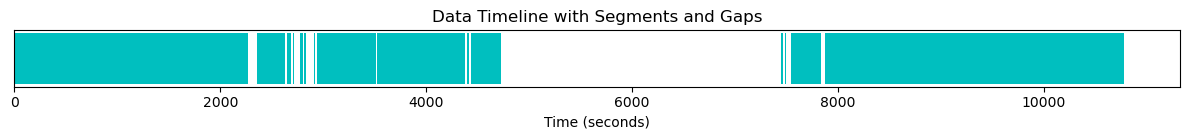

In [12]:
df = pd.DataFrame(real_data)
df = df.sort_values('timestamp')
df['time_diff'] = df['timestamp'].diff()

gap_threshold = 15.0
gaps = df[df['time_diff'] > gap_threshold]

segments = []
current_segment_start = df['timestamp'].iloc[0]

for idx, row in gaps.iterrows():
    segment_end = row['timestamp'] - row['time_diff']
    
    # Count data points in this segment
    segment_data = df[(df['timestamp'] >= current_segment_start) & 
                      (df['timestamp'] <= segment_end)]
    num_points = len(segment_data)
    
    segments.append({
        'start': current_segment_start,
        'end': segment_end,
        'duration': segment_end - current_segment_start,
        'num_points': num_points
    })
    
    current_segment_start = row['timestamp']

# Add the last segment (with data point count)
segment_data = df[(df['timestamp'] >= current_segment_start) & 
                  (df['timestamp'] <= df['timestamp'].iloc[-1])]
num_points = len(segment_data)

segments.append({
    'start': current_segment_start,
    'end': df['timestamp'].iloc[-1],
    'duration': df['timestamp'].iloc[-1] - current_segment_start,
    'num_points': num_points  # <-- New field: number of data points
})

# Convert to DataFrame for better visualization
segments_df = pd.DataFrame(segments)

# Print segment info (now includes point counts)
print("\nTime Segments Information:")
for i, segment in enumerate(segments):
    print(
        f"Segment {i+1}: "
        f"{segment['start']:.2f}s - {segment['end']:.2f}s | "
        f"Duration: {segment['duration']:.2f}s | "
        f"Points: {segment['num_points']}"
    )

# Time gaps
plt.figure(figsize=(12, 1.5))
timeline_y = 1
timeline_height = 0.05

total_time = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
plt.barh(timeline_y, total_time, height=timeline_height, left=df['timestamp'].iloc[0], color='white')

# Plot each segment
for segment in segments:
    plt.barh(
        timeline_y, 
        segment['duration'], 
        height=timeline_height, 
        left=segment['start'], 
        color='c'
    )

plt.xlabel('Time (seconds)')
plt.yticks([])
plt.title(f'Data Timeline with Segments and Gaps')
plt.tight_layout()
plt.savefig(f'timeline_{target_subject_base}_{date}.png')
plt.show()

# Store the segments
time_segments = []
for segment in segments:
    segment_data = df[(df['timestamp'] >= segment['start']) & 
                      (df['timestamp'] <= segment['end'])].copy()
    time_segments.append({
        'start': segment['start'],
        'end': segment['end'],
        'duration': segment['duration'],
        'data': segment_data
    })


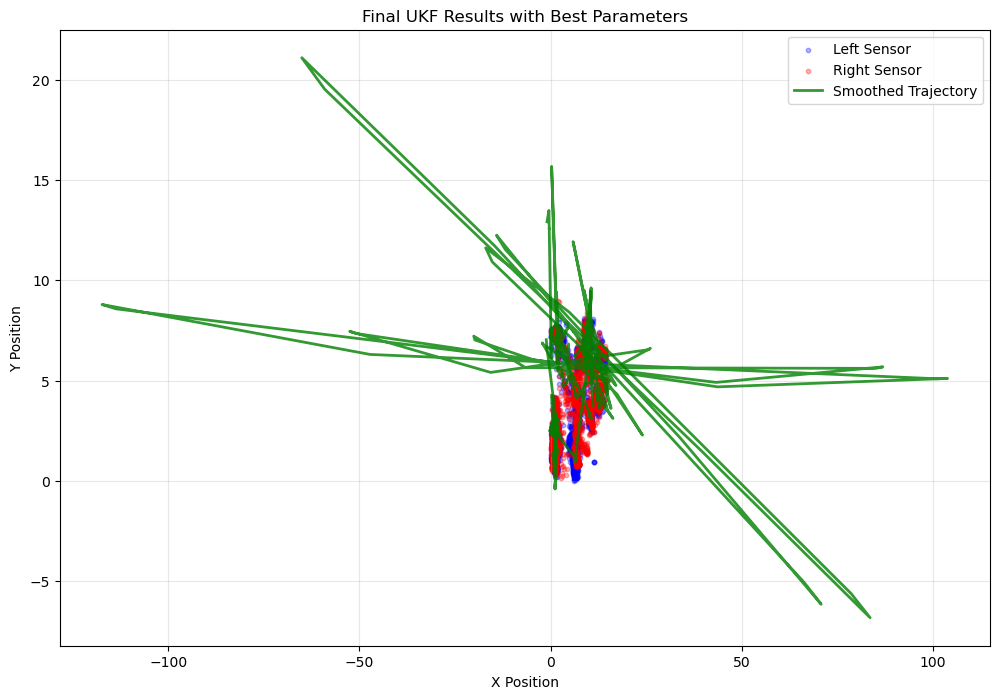

Final parameters used: [0.01, 0.001, 0.9999985476384518, 0.2300010549728482]
Final negative log-likelihood: 13051.591493054742


In [13]:
plt.figure(figsize=(12, 8))
plt.title('Final UKF Results with Best Parameters')

left_x, left_y = [], []
right_x, right_y = [], []
for entry in real_data:
    if 'left' in entry:
        left_x.append(entry['left'][0])
        left_y.append(entry['left'][1])
    if 'right' in entry:
        right_x.append(entry['right'][0])
        right_y.append(entry['right'][1])
plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)

first = True  # Flag to only label the smoothed trajectory once
for time_segment in time_segments:
    run_data = time_segment['data'].to_dict(orient='records')

    final_s_filt, final_P_filt, final_s_hat, final_P, final_neg_log_likelihood = ukf_forward(
        run_data,
        [entry['timestamp'] for entry in run_data],
        np.arange(min(entry['timestamp'] for entry in run_data),
                  max(entry['timestamp'] for entry in run_data),
                  DT_VIRT).tolist(),
        final_params
    )

    final_s_smooth, final_P_smooth = ukf_smoother(
        final_s_filt, final_P_filt, final_s_hat, final_P,
        [entry['timestamp'] for entry in run_data],
        np.arange(min(entry['timestamp'] for entry in run_data),
                  max(entry['timestamp'] for entry in run_data),
                  DT_VIRT).tolist(),
                  final_params
    )

    label = 'Smoothed Trajectory' if first else None
    first = False

    plt.plot(
        [s[0] for s in final_s_smooth],
        [s[1] for s in final_s_smooth],
        'g-', alpha=0.8, linewidth=2, label=label
    )

plt.grid(True, alpha=0.3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

print(f"Final parameters used: {final_params}")
print(f"Final negative log-likelihood: {final_neg_log_likelihood}")
